In [28]:
import torch
import torch.nn as nn
import torch.nn.init as init
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

class my_nn_model(nn.Module):
    def __init__(self, input_size=784, hidden_size=16, num_hidden_layers=8, output_size=10):
        super(my_nn_model, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Input layer: 784 -> 16
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Hidden layers: 16 -> 16 (8 layers total)
        for i in range(num_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Output layer: 16 -> 10
        self.output_layer = nn.Linear(hidden_size, output_size)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Flatten the input if it's in image format (B, 1, 28, 28) -> (B, 784)
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)
        
        # Pass through all hidden layers with ReLU activation
        for layer in self.layers:
            x = self.relu(layer(x))
        
        x = self.output_layer(x)
        
        return x

    def initialize_weights(self, d=None):
        """
        Initialize weights uniformly in [-d, d] and biases to 0.
        """
        for layer in self.layers:
            if d is None:
                # Xavier initialization: d = sqrt(6 / (ni + no))
                ni = layer.weight.size(1)
                no = layer.weight.size(0)
                bound = math.sqrt(6 / (ni + no))
            else:
                bound = d
            init.uniform_(layer.weight, -bound, bound)
            init.constant_(layer.bias, 0)
        
        # Output layer
        if d is None:
            ni = self.output_layer.weight.size(1)
            no = self.output_layer.weight.size(0)
            bound = math.sqrt(6 / (ni + no))
        else:
            bound = d
        init.uniform_(self.output_layer.weight, -bound, bound)
        init.constant_(self.output_layer.bias, 0)


net = my_nn_model().to(device)

print(net)
print(f"\nTotal parameters: {sum(p.numel() for p in net.parameters())}")

dummy_input = torch.randn(32, 784).to(device)  # Batch size 32, move to GPU
output = net(dummy_input)
print(f"\nInput shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Input device: {dummy_input.device}")
print(f"Output device: {output.device}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
my_nn_model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1-7): 7 x Linear(in_features=16, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (relu): ReLU()
)

Total parameters: 14634

Input shape: torch.Size([32, 784])
Output shape: torch.Size([32, 10])
Input device: cuda:0
Output device: cuda:0


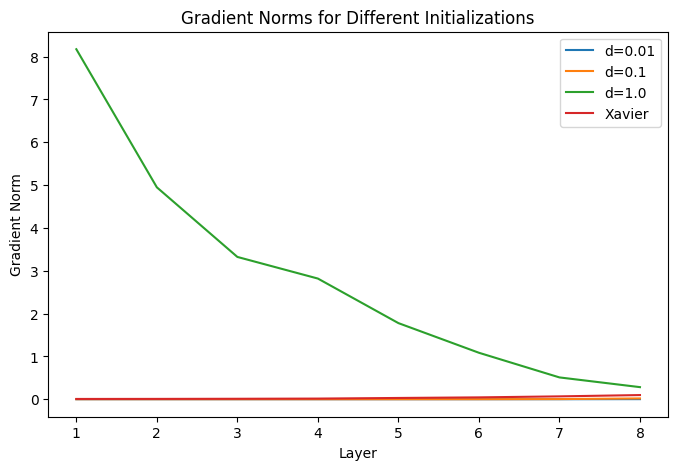

In [29]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Load a minibatch of FashionMNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Get one minibatch
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

def get_grad_norms(model, x, y):
    activations = []
    x = x.view(x.size(0), -1)
    
    for layer in model.layers:
        x = model.relu(layer(x))
        x.retain_grad()
        activations.append(x)
    
    out = model.output_layer(x)
    loss = nn.CrossEntropyLoss()(out, y)
    
    model.zero_grad()
    loss.backward()
    
    grad_norms = [act.grad.norm().item() for act in activations]
    return grad_norms

ds = [0.01, 0.1, 1.0, None]  # None = Xavier
plt.figure(figsize=(8,5))

for d in ds:
    net = my_nn_model().to(device)
    net.initialize_weights(d)
    norms = get_grad_norms(net, images, labels)
    label = f"d={d}" if d is not None else "Xavier"
    plt.plot(range(1, len(norms)+1), norms, label=label)

plt.xlabel("Layer")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norms for Different Initializations")
plt.legend()
plt.show()


Epoch 1: Train Acc=0.175, Test Acc=0.248
Epoch 2: Train Acc=0.392, Test Acc=0.543
Epoch 3: Train Acc=0.587, Test Acc=0.604
Epoch 4: Train Acc=0.664, Test Acc=0.674
Epoch 5: Train Acc=0.709, Test Acc=0.728


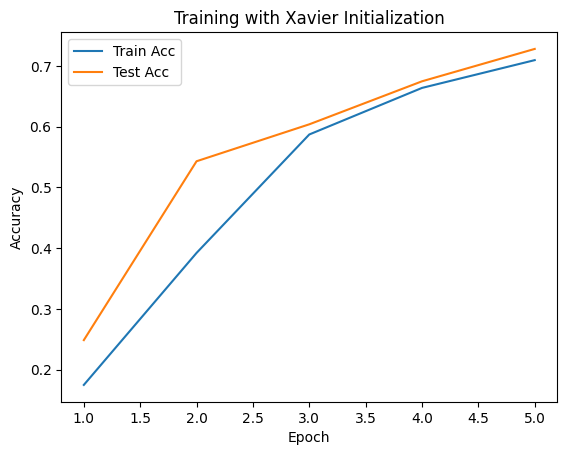

In [30]:
from torch.utils.data import DataLoader

def train_model(model, train_loader, test_loader, epochs=5, lr=0.01):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    train_acc, test_acc = [], []
    
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x = x.view(x.size(0), -1)
            
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        
        train_acc.append(correct/total)
        
        # Test accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                x = x.view(x.size(0), -1)
                out = model(x)
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        test_acc.append(correct/total)
        print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.3f}, Test Acc={test_acc[-1]:.3f}")
    
    return train_acc, test_acc

# Data loaders
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Example: train with Xavier
net = my_nn_model().to(device)
net.initialize_weights(None)  # Xavier
train_acc, test_acc = train_model(net, train_loader, test_loader)

# Plot
plt.plot(range(1,6), train_acc, label="Train Acc")
plt.plot(range(1,6), test_acc, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training with Xavier Initialization")
plt.legend()
plt.show()


## Part E: Effect of Depth and Initialization

Proper initialization strongly influences gradient flow in deep networks. Small weights (e.g., 
d=0.01
d=0.01) cause vanishing gradients, while large ones (e.g., 
d=1.0
d=1.0) can lead to exploding gradients. Xavier initialization keeps activations and gradients balanced across layers, resulting in smoother gradient norms, faster convergence, and higher accuracy. Deeper networks are more sensitive to initialization, making stable schemes like Xavier essential.

Epoch 1: Train Acc=0.172, Test Acc=0.200
Epoch 2: Train Acc=0.278, Test Acc=0.362
Epoch 3: Train Acc=0.427, Test Acc=0.510
Epoch 4: Train Acc=0.584, Test Acc=0.630
Epoch 5: Train Acc=0.668, Test Acc=0.571
Epoch 1: Train Acc=0.185, Test Acc=0.336
Epoch 2: Train Acc=0.370, Test Acc=0.402
Epoch 3: Train Acc=0.517, Test Acc=0.618
Epoch 4: Train Acc=0.638, Test Acc=0.624
Epoch 5: Train Acc=0.691, Test Acc=0.692
Epoch 1: Train Acc=0.168, Test Acc=0.300
Epoch 2: Train Acc=0.382, Test Acc=0.474
Epoch 3: Train Acc=0.588, Test Acc=0.652
Epoch 4: Train Acc=0.679, Test Acc=0.712
Epoch 5: Train Acc=0.722, Test Acc=0.739


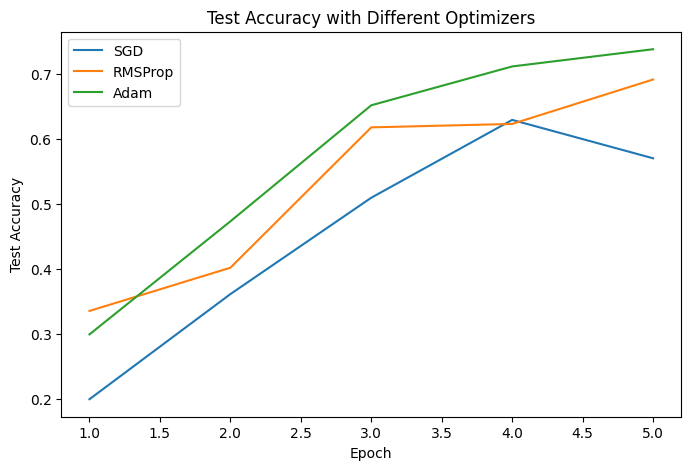

In [31]:
optimizers = {
    "SGD": torch.optim.SGD,
    "RMSProp": torch.optim.RMSprop,
    "Adam": torch.optim.Adam
}

plt.figure(figsize=(8,5))

for name, opt_class in optimizers.items():
    net = my_nn_model().to(device)
    net.initialize_weights(None)  # Xavier
    optimizer = opt_class(net.parameters(), lr=0.01)
    
    # train for 5 epochs
    train_acc, test_acc = train_model(net, train_loader, test_loader)
    plt.plot(range(1,6), test_acc, label=name)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy with Different Optimizers")
plt.legend()
plt.show()


## Part F: Optimizers

With Xavier initialization, SGD converges slowly but steadily, RMSProp adapts faster with some noise, and Adam achieves the quickest and most stable convergence. Overall, Adam provides the best balance between training speed and test performance, while SGD offers smoother but slower learning.